## Trailing losses ##

Trailing losses occur for moving objects when their motion during an exposure (or visit) makes them cover an area larger than the PSF. This notebook investigates the SNR losses due to trailing, as expected for LSST (with its 2-snap per visit observations) and the effect of DM source detection on the limiting magnitude expected for a visit. 
There are also some visualizations of what moving objects might look like in LSST visits (including the dip or gap that may occur in the trail due to 2 snaps per visit observations), and an estimate of what fraction of NEOs or PHAs may be affected by these trailing losses.

Note that for LSST, each visit is composed of 2 shorter exposures. The pair is used to reject cosmic rays, but will be simply added together for a single visit limiting magnitude equivalent to the combination of the two visits (LSST is sky-noise limited in all bands except u band, which also has a non-negligble read-noise contribution). The spacing between the two exposures is nominally 2 seconds (the readout time), however the shutter requires 1 second to move across the field of view. The shutter is composed of two blades which travel across the fov one after another (e.g. one blade 'opens' the camera, the second blade 'closes' it; for the next exposure, the second blade 'opens', followed by the first blade 'closing' the camera and returning to the starting positions). Thus, the midpoint of any particular exposure varies by 1 second across the fov but the total exposure time is constant. The 'gap' between a pair of exposures in a visit varies from 2 seconds to 4 seconds, depending on location in the fov relative to the shutter movement. 

If the shutter is opening L-R then R-L, then a point on the L side of the camera will have an exposure midpoint 1 second earlier than a point on the R side of the camera, will have a 4 second gap between exposures instead of a 2 second gap, and have the midpoint of the second exposure 1 second later than the R side of the camera. This may complicate trailing calculations. 

Each object will have the same trail length in the individual exposures, and the same overall 'central' location, but slightly different combined trail length due to variation in length of gap in middle of the visit. 

---
Simple example of motion (just to show gap between exposures in a single visit).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

0.354166666667 0.354166666667


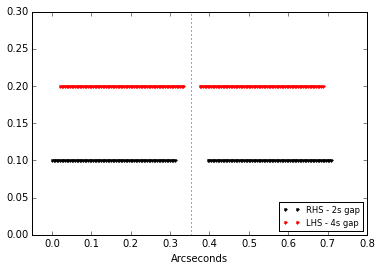

In [2]:
# simple motion - no PSF, just showing the 'gap' between snaps
velocity = 0.5 #deg/day
velocity = velocity /24.0 #arcseconds/second
exposuretime = np.arange(0, 15.01, 0.2) #seconds
timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
#print timesL.mean(), timesL.min(), timesL.max()
#print timesR.mean(), timesR.min(), timesR.max()
positionL = velocity * timesL
positionR = velocity * timesR
plt.figure()
plt.plot(positionL, np.zeros(len(positionL))+0.1, 'k.', label='RHS - 2s gap')
plt.plot(positionR, np.zeros(len(positionR))+0.2, 'r.', label='LHS - 4s gap')
plt.ylim(0, 0.3)
plt.xlim(-0.05, None)
plt.xlabel('Arcseconds')
plt.legend(loc='lower right', fontsize='smaller')
plt.axvline(positionL.mean(), color='g', linestyle=':')
print positionL.mean(), positionR.mean()

---
#PSF#

Now let's add in the seeing distribution, to look at the flux profile of the sources. 

Assume the PSF (for a stationary source) is consistent with Kolmogorov turbulence (see section 4.4 of the [SNR doc](http://ls.st/lse-40)). For moving objects, we can create many 'stationary' PSFs, at a series of locations along the trail of the object.

A good description of the PSF is a double-gaussian: (eqn 30 SNR doc) 
\begin{equation}
p_K(r | \alpha) \, =  \, 0.909 \left( p(r | \alpha) + 0.1 p(r | 2\alpha) \right) \\
p(r | \alpha) \, = \frac{1}{2 \pi \alpha^2} exp( \frac{-r^2}{2 \alpha^2})
\end{equation}

In [3]:
from scipy import integrate 

def sumPSF(x, y, flux):
    dx = np.min(np.diff(x))
    dy = np.min(np.diff(y))
    sumVal = integrate.simps(integrate.simps(flux, dx=dx), dx=dy)
    #sumVal = np.trapz(np.trapz(flux, dx=dx),dx=dy)
    return sumVal 

In [4]:
from scipy import interpolate 

def zoomImage(x, y, flux, zoom=[-1, 1, -1, 1], zmax=None, nbins=200.0, pixelize=False, pixelscale=0.2):
    """Zoom in and show the image in region 'zoom'.
    'pixelize' translates x/y into pixels and displays the image as would-be-seen with pixels."""
    if zmax is None:
        zmax = flux.max()
    if pixelize:
        x_pix = x / pixelscale
        y_pix = y / pixelscale
        xg = np.arange(zoom[0], zoom[1]+0.5, 1)
        yg = np.arange(zoom[2], zoom[3]+0.5, 1)
        xgrid, ygrid = np.meshgrid(xg, yg)
        showflux = interpolate.interpn((y_pix, x_pix), flux, (ygrid, xgrid),
                                      method='splinef2d', bounds_error=False, fill_value=0)
        plt.imshow(showflux, extent=zoom, vmin=0, vmax=zmax, origin='lower', interpolation='none',
                  cmap='gray')
        plt.colorbar()
        plt.xlabel('Pixels')
        plt.ylabel('Pixels')
    else:
        nbins = float(nbins)
        binsize = (zoom[1]-zoom[0])/nbins
        xg = np.arange(zoom[0], zoom[1]+binsize, binsize)
        binsize = (zoom[3] - zoom[2])/nbins
        yg = np.arange(zoom[2], zoom[3]+binsize, binsize)
        xgrid, ygrid = np.meshgrid(xg, yg)
        showflux = interpolate.interpn((y, x), flux, (ygrid, xgrid), 
                                       method='splinef2d', bounds_error=False, fill_value=0)
        plt.imshow(showflux, extent=zoom, vmin=0, vmax=zmax, origin='lower', interpolation='none', cmap='gray')
        plt.colorbar()
        plt.xlabel('Arcseconds')
        plt.ylabel('Arcseconds')

In [5]:
def singleGaussianStationaryPSF(seeing, totalflux=1, xcen=0, ycen=0, stepsize=0.01, alpharad=10.0):
    "Distribute flux across PSF. seeing in arcseconds"
    # Translate 'seeing' FWHM to gaussian 'sigma' (alpha in the equations above)
    alpha = seeing / np.sqrt(8 * np.log(2))
    maxrad = alpha*alpharad
    x = np.arange(0, 2*maxrad, stepsize) 
    x = x - x.mean() + xcen
    y = np.arange(0, 2*maxrad, stepsize)
    y = y - y.mean() + ycen
    xi, yi = np.meshgrid(x, y)
    radius = np.sqrt((xi-xcen)**2 + (yi-ycen)**2)
    p = 1.0/(2.0*np.pi*alpha**2) * np.exp(-radius**2/(2.0*alpha**2))
    flux = p / sumPSF(x, y, p) * totalflux
    # Flux = flux[y][x], although here it doesn't matter because len(x) = len(y)
    return x, y, flux

In [6]:
def stationaryPSF(seeing, totalflux=1, xcen=0, ycen=0, stepsize=0.01, alpharad=10.0):
    "Distribute flux across PSF. seeing in arcseconds"
    # Translate 'seeing' FWHM to gaussian 'sigma' (alpha in the equations above)
    alpha = seeing / np.sqrt(8 * np.log(2))
    maxrad = alpha*alpharad
    x = np.arange(0, 2*maxrad, stepsize) 
    x = x - x.mean() + xcen
    y = np.arange(0, 2*maxrad, stepsize)
    y = y - y.mean() + ycen
    xi, yi = np.meshgrid(x, y)
    radius = np.sqrt((xi-xcen)**2 + (yi-ycen)**2)
    p1 = 1.0/(2.0*np.pi*alpha**2) * np.exp(-radius**2/(2.0*alpha**2))
    p2 = 1.0/(2.0*np.pi*(2*alpha)**2) * np.exp(-radius**2/(2.0*(2*alpha)**2))
    p = 0.909*(p1 + 0.1*p2)
    flux = p / sumPSF(x, y, p) * totalflux
    # Flux = flux[y][x], although here it doesn't matter because len(x) = len(y)
    return x, y, flux

In [7]:
def crossSection(x, y, flux, xi=None, yi=None):
    """Take a cross-section at xi/yi and return the flux values."""
    if xi is None:
        xi = np.mean(x)
    if yi is None:
        yi = np.mean(y)
    # Find closest point in x/y arrays.
    xindx = np.argmin(np.abs(x-xi))
    yindx = np.argmin(np.abs(y-yi))
    fluxx = flux[yindx][:]
    fluxy = np.swapaxes(flux, 0, 1)[xindx][:]
    return fluxx, fluxy

Check these tools out with stationary PSF.

In [8]:
x, y, flux = stationaryPSF(0.7, totalflux=1)
sumPSF(x, y, flux)

1.0000000000000002

1.0
1.0
1.0


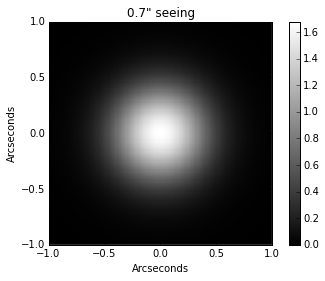

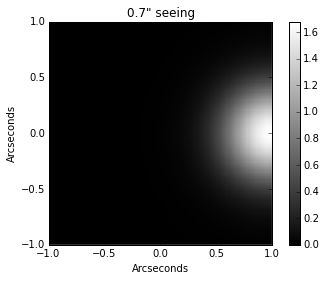

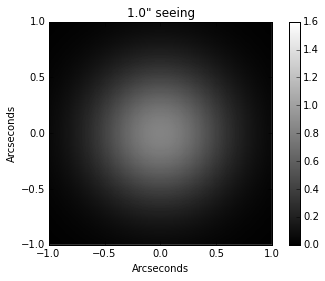

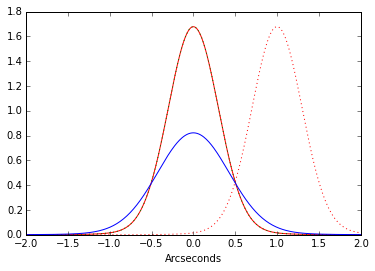

In [9]:
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
x1 = x
fx1 = fluxx
x, y, flux = stationaryPSF(0.7, xcen=1)
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux, xi=1)
x2 = x
fx2 = fluxx
y2 = y
fy2 = fluxy

x, y, flux = stationaryPSF(1.0, totalflux=1)
print sumPSF(x, y, flux)
plt.figure()
zoomImage(x, y, flux, zmax=1.6)
plt.title('1.0" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.plot(x1, fx1, 'r')
plt.plot(x2, fx2, 'r:')
plt.plot(y2, fy2, 'g:')
plt.plot(x, fluxx, 'b')
plt.xlim(-2, 2)
plt.xlabel('Arcseconds')

#Moving object PSF#

Now simulate a moving object as a series of stationary PSFs, summing all the flux vlaues contributed by each stationary PSF.

In [10]:
def movingPSF(velocity=1.0, seeing=0.7, totalflux=1., side='L'):
    "Simulate a moving object;  velocity (deg/day), seeing(arcsecond), side='L' or 'R' (L=4sec gap)"""
    velocity = velocity / 24.0 #arcsecond/second
    exposureTimeSteps = seeing/velocity/20.0
    exposuretime = np.arange(0, 15+exposureTimeSteps/2.0, exposureTimeSteps) #seconds
    timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
    timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
    positionL = velocity * timesL
    positionR = velocity * timesR
    xlist = []
    ylist = []
    fluxlist = []
    if side=='L':
        positions = positionL
    else:
        positions = positionR
    for p in (positions):
        xcen = p
        x, y, flux = stationaryPSF(seeing, xcen=xcen, ycen=0)
        xlist.append(x)
        ylist.append(y)
        fluxlist.append(flux)

    xmin = np.array([x.min() for x in xlist]).min()
    xmax = np.array([x.max() for x in xlist]).max()
    ymin = np.array([y.min() for y in ylist]).min()
    ymax = np.array([y.max() for y in ylist]).max()
    stepsize = 0.01 #arcseconds
    x = np.arange(xmin, xmax+stepsize, stepsize)
    y = np.arange(ymin, ymax+stepsize, stepsize)
    xgrid, ygrid = np.meshgrid(x, y)
    flux = np.zeros(np.shape(xgrid), float)
    for xi, yi, fi in zip(xlist, ylist, fluxlist):
        f = interpolate.interpn((yi, xi), fi, (ygrid, xgrid), bounds_error=False, fill_value=0)
        flux += f
    fluxSum = sumPSF(x, y, flux)
    flux = flux / fluxSum * totalflux
    return x, y, flux

In [11]:
velocity = 1.0 #deg/day
seeing = 0.7 #arcseconds
x, y, flux = movingPSF(velocity=velocity, seeing=seeing, totalflux=1000.0)
print sumPSF(x, y, flux)

1000.0


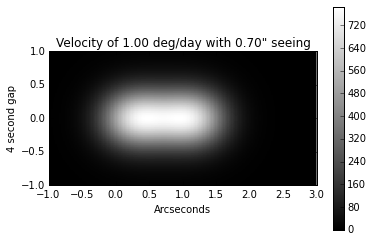

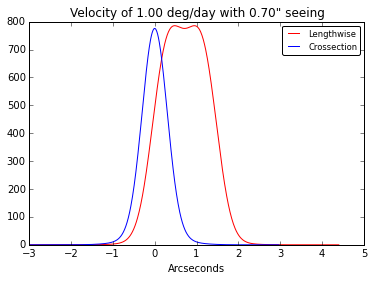

In [12]:
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('4 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

Above is with a smooth sub-pixel sampling. At 1 deg/day, on the 4 second gap (L) hand side of the chip, there is a dip in the smoothly sampled flux. However, it's small in width - the tracks are only separated by about 0.1", which is less than a pixel (0.2"/pixel for LSST). We can look at how the flux would appear if it was only sampled at the center of each pixel. 

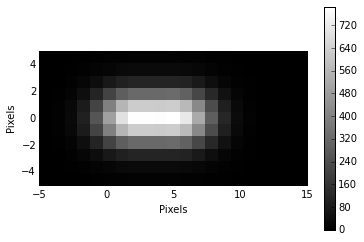

In [13]:
# try pixelizing the flux
pixelscale = 0.2
# 1 deg/day not nyquist sampled; 2 deg/day is definitely visible!
zoom=[-1, 3, -1, 1]
zoompix = [int(z/pixelscale) for z in zoom]
zoomImage(x, y, flux, zoom=zoompix, pixelize=True)

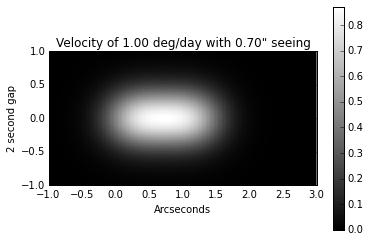

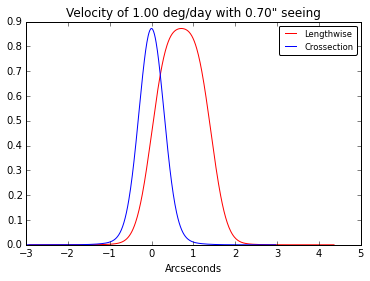

In [14]:
x, y, flux = movingPSF(side='R', velocity=velocity, seeing=seeing)
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('2 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)

plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

0.72825258521 0.72825258521


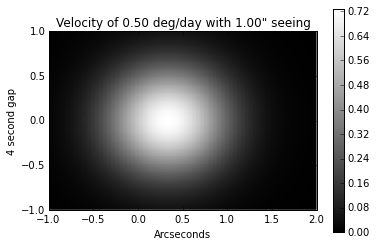

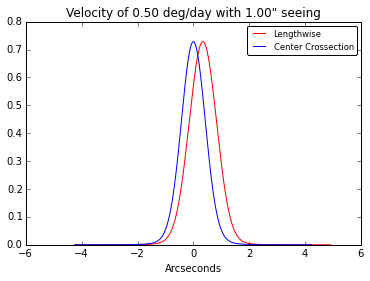

In [15]:
velocity=0.5
seeing=1.0
x, y, flux = movingPSF(side='L', velocity=velocity, seeing=seeing)
zoomImage(x, y, flux, zoom=[-1, 2, -1, 1])
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('4 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
print fluxx.max(), fluxy.max()

plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Center Crossection')
plt.legend(loc='upper right', fontsize='smaller', fancybox=True)
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

---
#SNR#

Calculating the SNR primarily comes down to calculating $n_{eff}$. 

We can calculate SNR (eqn 41 in SNR doc) (assuming gain=1):
\begin{equation}
SNR = \frac {C_b} {(C_b + n_{eff} (B_b + \sigma_I^2))^{1/2}}
\end{equation}
And equation 45-46 of the SNR doc invert this to:
\begin{equation}
C_b(SNR) = \frac{SNR^2}{2} + \left( \frac{SNR^4}{4}+ SNR^2 V_n \right) ^{1/2} \\
V_n = n_{eff} (B_b + \sigma_I^2) \\
\end{equation}

And then, as shown in eqn 26 of the SNR doc, $n_{eff}$ can be calculated as follows:
\begin{equation}
n_{eff} = \sum_i w_i = \frac{1}{\sum_i p_i^2} \\
\end{equation}

For a double gaussian, this is approximately equivalent to
\begin{equation}
n_{eff} = 2.436 \, (FWHM / pixelscale)^2 \\
\end{equation}
and for the simplification of a single gaussian PSF, it is exactly equivalent to
\begin{equation}
n_{eff} = 2.266 \, (FWHM / pixelscale)^2 \\
\end{equation}

In [16]:
from scipy import integrate

def calcNeff(x, y, psfprofile, pixelscale=0.2):
    # Find dx/dy intervals for integration. They should be uniform based on methods here.
    # numpy says they are, but somehow the diff returns multiple versions ?? (is this the bug?)
    dx = np.max(np.diff(x))
    dy = np.max(np.diff(y))
    # Make sure psfprofile normalizes to 1.
    psfSum = integrate.simps(integrate.simps(psfprofile, dx=dx), dx=dy)
    psfprofile /= psfSum
    # Calculate neff (area), in 'numerical steps'
    neff = 1.0 / integrate.simps(integrate.simps(psfprofile**2, dx=dx), dx=dy)
    # Convert to pixels (the 'neff' above is in arcseconds^2)
    neff = neff / (pixelscale**2)
    return neff

In [17]:
# Calculate Neff for stationary sources.
pixelscale = 0.2 #arcseconds/pixel
FWHM = 0.7 #arcseconds  ('seeing')

# For a single gaussian PSF
x, y, flux = singleGaussianStationaryPSF(seeing=FWHM, totalflux=1.0, alpharad=20.0, stepsize=0.01)
neff = calcNeff(x, y, flux, pixelscale=pixelscale)
neff_analytic = 2.266 * (FWHM/pixelscale)**2
print 'Single Gaussian:'
print 'Analytic Neff', neff_analytic
print 'Calculated neff from PSF',  neff
print '% difference:', (neff-neff_analytic)/neff_analytic*100.0

# For a double gaussian PSF
# See note after equation 33 in SNR doc - 
#  suggests seeing = 1.035 * FWHM for a double-gaussian. 
seeing = FWHM * 1.035
neff_analytic = 2.436 * (seeing/pixelscale)**2
# Calculate Neff from sum(1/p) for each pixel.
x, y, flux = stationaryPSF(seeing=FWHM, totalflux=1.0, alpharad=20.0, stepsize=0.01)
neff = calcNeff(x, y, flux, pixelscale=pixelscale)
print 'Double Gaussian (adjusted FWHM/seeing value):'
print 'Analytic Neff', neff_analytic
print 'Calculated neff from PSF',  neff
print '% difference:', (neff-neff_analytic)/neff_analytic*100.0

Single Gaussian:
Analytic Neff 27.7585
Calculated neff from PSF 27.7607058687
% difference: 0.00794664229063
Double Gaussian (adjusted FWHM/seeing value):
Analytic Neff 31.966425225
Calculated neff from PSF 31.0304425876
% difference: -2.92801785237


In [18]:
# So calculate Neff for moving sources - example:
velocity = 0.5
seeing = 0.7
x, y, flux = movingPSF(side='L', velocity=velocity, seeing=seeing, totalflux=1.0)
neff = calcNeff(x, y, flux)
print 'Calculated neff from PSF (LHS), velocity %.2f seeing %.1f: %f' %(velocity, seeing, neff)
x, y, flux = movingPSF(side='R', velocity=velocity, seeing=seeing, totalflux=1.0)
neff = calcNeff(x, y, flux)
print 'Calculated neff from PSF (RHS), velocity %.2f seeing %.1f: %f' %(velocity, seeing, neff)

Calculated neff from PSF (LHS), velocity 0.50 seeing 0.7: 38.864290
Calculated neff from PSF (RHS), velocity 0.50 seeing 0.7: 37.669208


In [19]:
# Calculate totalflux equivalent to (optimally extracted) SNR=5.0 for this range of velocities.
SNR = 5.0
sky = 2000.
inst_noise = 10.0
Vn = neff*(sky + inst_noise)
counts =  SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
mags = 2.5*np.log10(counts)
# and for a stationary source.
x, y, flux = stationaryPSF(seeing=seeing, totalflux=1.)
neff_stat = calcNeff(x, y, flux)
Vn = neff_stat*(sky + inst_noise)
counts = SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
mag_stat = 2.5*np.log10(counts) 
# Subtract the two to find the magnitude increase required to stay at SNR=5.0 (optimal extraction) as objects trail.
mag_diff = mags - mag_stat
print mag_stat, "=m5 for a stationary source (corresponds to SNR=5)"
print mags, "= m5 for for an object moving", velocity, "deg/day in", seeing, "arcsec seeing"
print "difference: ", mag_diff

7.75202331664 =m5 for a stationary source (corresponds to SNR=5)
7.85626751764 = m5 for for an object moving 0.5 deg/day in 0.7 arcsec seeing
difference:  0.104244200996


This result matches closely with the trailing loss formula used in the LSST Overview paper, so it looks about right. This is the inevitable loss in SNR due to the fact that the moving object trails across more sky pixels, thus adding more sky noise into the measurement of its (optimally extracted) source. 

---
We also need to look at the effect that results from DM's source detection algorithms. DM will only detect sources which are brighter than some threshhold (currently 5$\sigma$) in a PSF-convolved image. Because our sources are moving, their peak fluxes (convolved with the stationary PSF) will be lower than a similar stationary source.

1261.27366141 1261.27366141 12612736.6719


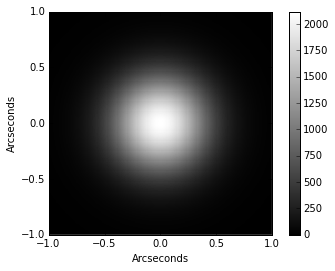

In [20]:
# Find counts at threshhold for stationary source. 
seeing = 0.7
SNR = 5.0
sky = 2000.
inst_noise = 10.0
x, y, flux = stationaryPSF(seeing=seeing, totalflux=1)
neff_stat = calcNeff(x, y, flux)
Vn = neff_stat*(sky + inst_noise)
counts_stat = SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
x_stat, y_stat, flux_stat = stationaryPSF(seeing=seeing, totalflux=counts_stat) 
zoomImage(x_stat, y_stat, flux_stat)
print counts_stat, sumPSF(x_stat, y_stat, flux_stat), flux_stat.sum()

1261.27366141 1261.27366141 12612736.6433


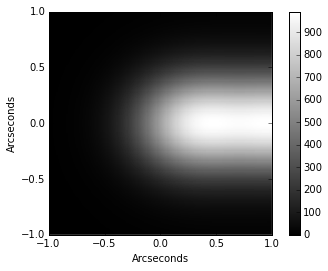

In [21]:
# Distribute same counts in moving object.
velocity = 1.0
x_mo, y_mo, flux_mo = movingPSF(seeing=seeing, velocity=velocity, totalflux=counts_stat)
zoomImage(x_mo, y_mo, flux_mo)
print counts_stat, sumPSF(x_mo, y_mo, flux_mo), flux_mo.sum()

max counts for stationary / moving objects: 2116.80110163 / 990.579271132
total flux across stationary object 1261.27366141
total flux across moving object 1261.27366141


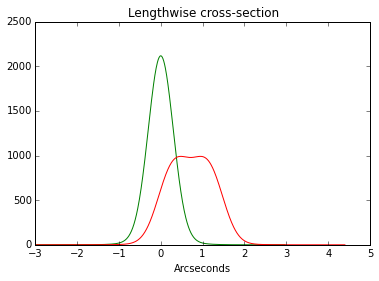

In [22]:
# Compare the peak brightness of the two (without correlation with PSF)
fx_stat, fy_stat = crossSection(x_stat, y_stat, flux_stat)
fx_mo, fy_mo = crossSection(x_mo, y_mo, flux_mo)
plt.plot(x_stat, fx_stat, 'g')
plt.plot(x_mo, fx_mo, 'r')
plt.xlabel("Arcseconds")
plt.title('Lengthwise cross-section')
print 'max counts for stationary / moving objects:', flux_stat.max(), '/', flux_mo.max()
print 'total flux across stationary object', sumPSF(x_stat, y_stat, flux_stat)
print 'total flux across moving object', sumPSF(x_mo, y_mo, flux_mo)

In [23]:
# Generate a PSF profile that we will correlate with the stationary and moving object sources 
# (this is the LSST detection filter)
x_psf, y_psf, psfprofile = stationaryPSF(seeing=seeing, totalflux=1.0, stepsize=0.01, alpharad=10.0)

Max counts in filtered image (~ sum of total flux) 10161585.086
total flux in original image, simple sum without account for pixel size 12612736.6719
Max counts in original image 2116.80110163


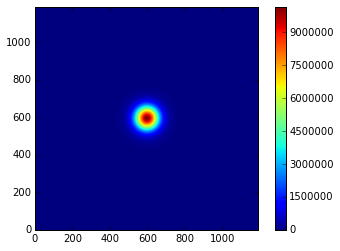

In [24]:
from scipy import signal
filtered_stat = signal.fftconvolve(flux_stat, psfprofile)
plt.imshow(filtered_stat, origin='lower')
plt.colorbar()
print 'Max counts in filtered image (~ sum of total flux)', filtered_stat.max()
print 'total flux in original image, simple sum without account for pixel size', flux_stat.sum()
print 'Max counts in original image', flux_stat.max()

Max counts in filtered image 6533104.59533
total counts in original image (sum without account for pixel size) 12612736.6433
Max counts in original image 990.579271132


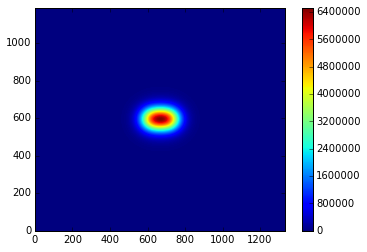

In [25]:
filtered_mo = signal.fftconvolve(flux_mo, psfprofile)
plt.imshow(filtered_mo, origin='lower')
plt.colorbar()
print 'Max counts in filtered image', filtered_mo.max()
print 'total counts in original image (sum without account for pixel size)', flux_mo.sum()
print 'Max counts in original image', flux_mo.max()

In [26]:
# So how much brighter do we have to get as a moving object in order to hit the 
#  out_stat.max() value, which is the detection threshhold?
ratio = filtered_stat.max() / filtered_mo.max()
print "increasing counts in moving object by", ratio
dmag = 2.5*np.log10(ratio)
print "equivalent to change in magnitude of", dmag
flux_mo2 = flux_mo * ratio

increasing counts in moving object by 1.55539911197
equivalent to change in magnitude of 0.479604616668


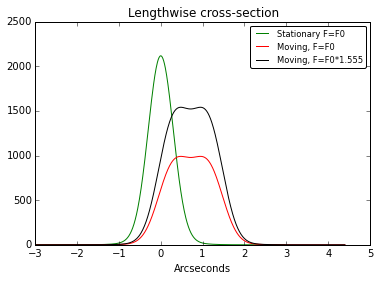

In [27]:
# Just look at the cross-sections, 
# see that even with the increase of 1.55 in flux that we're still below the pix level of the stationary PSF.
# this is because along the 'line' of the velocity, the flux doesn't fall as fast as a stationary PSF
fx_stat, fy_stat = crossSection(x_stat, y_stat, flux_stat)
fx_mo, fy_mo = crossSection(x_mo, y_mo, flux_mo)
fx_mo2, fy_mo2 = crossSection(x_mo, y_mo, flux_mo2)
plt.plot(x_stat, fx_stat, 'g', label='Stationary F=F0')
plt.plot(x_mo, fx_mo, 'r', label='Moving, F=F0')
plt.plot(x_mo, fx_mo2, 'k', label='Moving, F=F0*%.3f' %(ratio))
plt.legend(loc='upper right', fancybox=True, fontsize='smaller')
plt.xlabel("Arcseconds")
plt.title('Lengthwise cross-section')

Set up and repeat the experiment for a variety of different seeings, and both sides of the chip. 
(warning  - this is pretty slow). 

In [28]:
det_loss = {}
trail_loss = {}
seeings = [0.7, 1.0, 1.2]
velocities = np.concatenate([np.arange(0.02, 2.5, 0.2), np.arange(2.8, 4.0, 0.3), np.arange(4.5, 10, 0.5)])
sides = ['L', 'R']

In [29]:
# Find counts at threshhold for stationary source. 
for side in sides:
    det_loss[side] = {}
    trail_loss[side] = {}
    for seeing in seeings:
        SNR = 5.0
        sky = 2000.  #these values should cancel
        inst_noise = 10.0
        x, y, flux = stationaryPSF(seeing=seeing, totalflux=1)
        neff_stat = calcNeff(x, y, flux)
        Vn = neff_stat*(sky + inst_noise)
        counts_stat = SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
        x_stat, y_stat, flux_stat = stationaryPSF(seeing=seeing, totalflux=counts_stat) 
        # Determine the PSF Profile for convolution (correlation, but we're symmetric)
        x_psf, y_psf, psfprofile = stationaryPSF(seeing=seeing, totalflux=1.0, stepsize=0.01, alpharad=10.0)
        # Calculated the filtered peak value for stationary sources - this is what we have to match.
        filtered_stat = signal.fftconvolve(flux_stat, psfprofile)

        # Calculate how much brighter (than a stationary obj) a moving object has to be to match the 
        #     peak level above in PSF filter (rather than moving object filter)
        # And calculate how much brighter (than stationary obj) a moving object has to be to hit SNR=5 
        #   even with optimal extraction
        det_loss[side][seeing] = np.zeros(len(velocities), float)
        trail_loss[side][seeing] = np.zeros(len(velocities), float)
        for i, v in enumerate(velocities):
            x, y, flux = movingPSF(seeing=seeing, velocity=v, totalflux=counts_stat, side=side)
            filtered_mo = signal.fftconvolve(flux, psfprofile)
            det_loss[side][seeing][i] = filtered_stat.max() / filtered_mo.max() 
            neff = calcNeff(x, y, flux)
            Vn = neff*(sky + inst_noise)
            counts_mo =  SNR**2/2. + np.sqrt(SNR**4/4. + SNR**2 * Vn)
            trail_loss[side][seeing][i] = counts_mo / counts_stat

In [30]:
# We have the 'blue curve'= minimum SNR losses due to increased area == 'trail_loss'
# We have the 'red curve' = max detection loss due to detection on PSF-filtered image instead of trailed PSF
# 'diff_loss' == the difference between them (potentially recoverable with increased work by DM)
diff_loss = {}
for side in sides:
    diff_loss[side] = {}
    for seeing in seeings:
        diff_loss[side][seeing] = det_loss[side][seeing]/trail_loss[side][seeing]

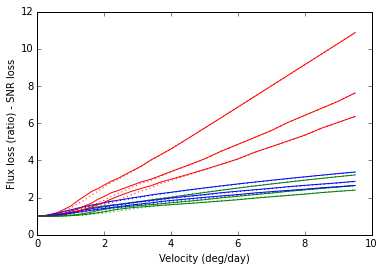

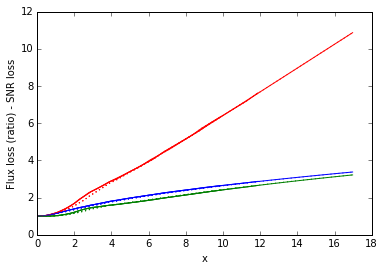

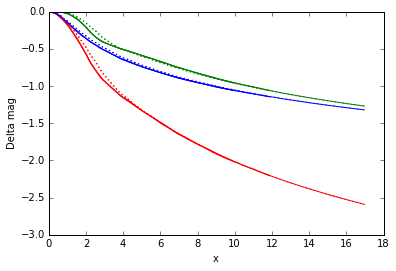

In [31]:
# red = detection losses due to detection on point-like PSF
# blue = snr losses due to increased area under moving object
# green = ratio between the two (red/blue)
# solid = LHS of focal plane (4s gap), dashed = RHS of focal plane (2s gap)
for side in sides:
    if side == 'L':
        linestyle = '-'
    if side == 'R':
        linestyle = ':'
    plt.figure(1)
    for seeing in seeings:
        plt.plot(velocities, det_loss[side][seeing], color='r', linestyle=linestyle)
        plt.plot(velocities, trail_loss[side][seeing], color='b', linestyle=linestyle)
        plt.plot(velocities, diff_loss[side][seeing], color='g', linestyle=linestyle)
        plt.xlabel('Velocity (deg/day)')
        plt.ylabel('Flux loss (ratio) - SNR loss')
    
    plt.figure(2)
    for seeing in seeings:
        plt.plot(velocities*30.0/seeing/24.0, det_loss[side][seeing], color='r', linestyle=linestyle)
        plt.plot(velocities*30.0/seeing/24.0, trail_loss[side][seeing], color='b', linestyle=linestyle)
        plt.plot(velocities*30.0/seeing/24.0, diff_loss[side][seeing], color='g', linestyle=linestyle)
        plt.xlabel('x')
        plt.ylabel('Flux loss (ratio) - SNR loss')

    plt.figure(3)
    for seeing in seeings:
        plt.plot(velocities*30.0/seeing/24.0, -2.5*np.log10(det_loss[side][seeing]), color='r', linestyle=linestyle)
        plt.plot(velocities*30.0/seeing/24.0, -2.5*np.log10(trail_loss[side][seeing]), color='b', linestyle=linestyle)
        plt.plot(velocities*30.0/seeing/24.0, -2.5*np.log10(diff_loss[side][seeing]), color='g', linestyle=linestyle)
        plt.xlabel('x')
        plt.ylabel('Delta mag')

Fit functions to the detection and trailing losses.  We're looking for something probably like:

\begin{equation}
x = \frac{v T_{exp}} {\theta} \\ 
flux ratio = \sqrt{1 + a x^2 / (1 + b x)}\\
\end{equation}


In [32]:
from scipy.optimize import curve_fit
from scipy.special import erf, erfc

In [33]:
def vToX(v, t, seeing):
    return v * t / seeing / 24.0

def fitfunc(x, c1, c2):
    # x = velocities * t / seeing (/24.0)
    func = np.sqrt(1. + c1*x**2 / (1. + c2 *x))
    return func

def fitfunc2(x, c1, c2):
    func = 1 + c1*x**2 / (1.+c2*x)
    return func

print vToX(1.0, 30, 0.7)

1.78571428571


/Users/lynnej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


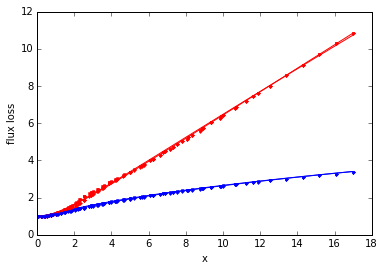

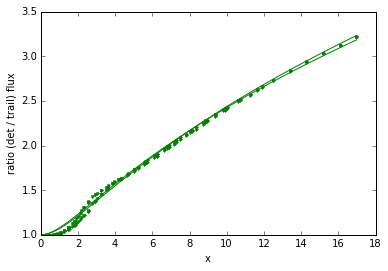

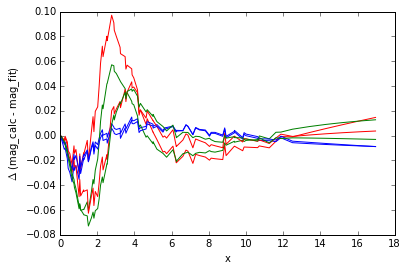

In [34]:
tExp = 30.0

xall = {}
trailall = {}
detall = {}
diffall = {}
for side in sides:
    # combine the data so that we can fit it all at once. 
    xall[side] = []
    detall[side] = []
    trailall[side] = []
    diffall[side] = []
    for s in seeings:
        x = vToX(velocities, tExp, s)
        xall[side].append(x)
        detall[side].append(det_loss[side][s])
        trailall[side].append(trail_loss[side][s])
        diffall[side].append(diff_loss[side][s])
    xall[side] = np.array(xall[side]).flatten()
    detall[side] = np.array(detall[side]).flatten()
    trailall[side] = np.array(trailall[side]).flatten()
    diffall[side] = np.array(diffall[side]).flatten()
    xarg = np.argsort(xall[side])
    detall[side] = detall[side][xarg]
    trailall[side] = trailall[side][xarg]
    xall[side] = xall[side][xarg]
    diffall[side] = diffall[side][xarg]
    
# Fit the data. 
trailab = {}
detab = {}
diffab = {}
for side in sides:
    trailab[side] = {}
    detab[side] = {}
    diffab[side] = {}
    popt, pcov = curve_fit(fitfunc, xall[side], trailall[side])
    trailab[side]['a'] = popt[0]
    trailab[side]['b'] = popt[1]
    popt, pcov = curve_fit(fitfunc, xall[side], detall[side])
    detab[side]['a'] = popt[0]
    detab[side]['b'] = popt[1]
    popt, pcov = curve_fit(fitfunc, xall[side], diffall[side])
    diffab[side]['a'] = popt[0]
    diffab[side]['b'] = popt[1]

# Residuals?
dl = {}
tl = {}
dd = {}
for side in sides:
    dl[side] = fitfunc(xall[side], detab[side]['a'], detab[side]['b'])
    tl[side] = fitfunc(xall[side], trailab[side]['a'], trailab[side]['b'])
    dd[side] = fitfunc(xall[side], diffab[side]['a'], diffab[side]['b'])


# Plot data
for side in sides:
    plt.plot(xall[side], dl[side], 'r-')
    plt.plot(xall[side], tl[side], 'b-')
    plt.plot(xall[side], detall[side], 'r.')
    plt.plot(xall[side], trailall[side], 'b.')
    plt.xlabel('x')
    plt.ylabel('flux loss')

plt.figure()
for side in sides:
    plt.plot(xall[side], dd[side], 'g-')
    plt.plot(xall[side], diffall[side], 'g.')
    plt.xlabel('x')
    plt.ylabel('ratio (det / trail) flux')

# plot diffs.
plt.figure()
for side in sides:
    diff_dl = 2.5*np.log10(detall[side] / dl[side])
    diff_tl = 2.5*np.log10(trailall[side] / tl[side])
    eps = 1e-20
    diff_dd = 2.5*np.log10(diffall[side] / dd[side])
    
    plt.plot(xall[side], diff_dl, 'r-')
    plt.plot(xall[side], diff_tl, 'b-')
    plt.xlabel('x')
    plt.ylabel('$\Delta$ (mag_calc - mag_fit)')

    plt.plot(xall[side], diff_dd, 'g-')
    plt.xlabel('x')
    plt.ylabel('$\Delta$ (mag_calc - mag_fit)')

Fitting the trailing losses with a simple polynomial seems to do slightly better, but results in a more complicated result. A third order polynomial is not enough to capture the wiggles near x=0, so deg=4 it is. Actually, deg=5 does better at not adding additional losses near velocity=0, which is an important area.

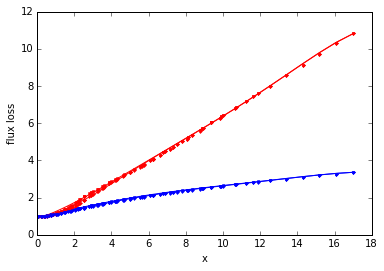

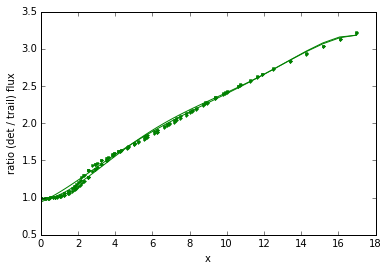

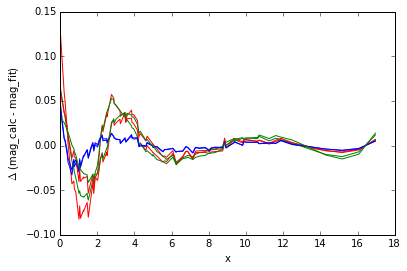

In [35]:
trailp = {}
detp = {}
diffp = {}
deg = 5
for side in sides:
    trailp[side] = np.polyfit(xall[side], trailall[side], deg=deg)
    detp[side] = np.polyfit(xall[side], detall[side], deg=deg)
    diffp[side] = np.polyfit(xall[side], diffall[side], deg=deg)
    
    
# Residuals?
dl = {}
tl = {}
dd = {}
for side in sides:
    dl[side] = np.polyval(detp[side], xall[side])
    tl[side] = np.polyval(trailp[side], xall[side])
    dd[side] = np.polyval(diffp[side], xall[side])

# plot
for side in sides:
    plt.plot(xall[side], dl[side], 'r-')
    plt.plot(xall[side], tl[side], 'b-')
    plt.plot(xall[side], detall[side], 'r.')
    plt.plot(xall[side], trailall[side], 'b.')
    plt.xlabel('x')
    plt.ylabel('flux loss')

plt.figure()
for side in sides:
    plt.plot(xall[side], dd[side], 'g-')
    plt.plot(xall[side], diffall[side], 'g.')
    plt.xlabel('x')
    plt.ylabel('ratio (det / trail) flux')

plt.figure()
for side in sides:
    plt.plot(xall[side], 2.5*np.log10(detall[side]/dl[side]), 'r-')
    plt.plot(xall[side], 2.5*np.log10(trailall[side]/tl[side]), 'b-')
    plt.xlabel('x')
    plt.ylabel('$\Delta$ (mag_calc - mag_fit)')
    eps = 1e-20
    diff_dd = 2.5*np.log10(diffall[side] / dd[side])
    plt.plot(xall[side], diff_dd, 'g-')

In [36]:
for side in sides:
    print 'side', side
    print 'a/b'
    print 'trailing loss params : a,b', trailab[side]['a'], trailab[side]['b']    
    print 'detection loss params: a,b', detab[side]['a'], detab[side]['b']    
    print 'ratio params: a,b', diffab[side]['a'], diffab[side]['b']
    print 'p'
    print 'trailing loss params: p', trailp[side]
    print 'detection loss params: p, ', detp[side]
    print 'ratio params: p', diffp[side]
    
print 'Average a/b"s:' 
print 'trailing loss:', (trailab['L']['a'] + trailab['R']['a'])/2.0, (trailab['L']['b'] + trailab['R']['b'])/2.0
print 'detection loss:', (detab['L']['a'] + detab['R']['a'])/2.0, (detab['L']['b'] + detab['R']['b'])/2.0
print 'difference det-trail', (diffab['L']['a'] + diffab['R']['a'])/2.0, (diffab['L']['b'] + diffab['R']['b'])/2.0

side L
a/b
trailing loss params : a,b 0.920734046087 1.4169297694
detection loss params: a,b 0.431955245795 0.0053571076203
ratio params: a,b 0.217994246313 0.346470882514
p
trailing loss params: p [ -5.29500760e-06   2.19397497e-04  -2.95124468e-03   8.65400208e-03
   2.11945061e-01   9.51532325e-01]
detection loss params: p,  [ -1.78979546e-05   7.56237969e-04  -1.16129979e-02   8.36873676e-02
   2.97513833e-01   8.81788708e-01]
ratio params: p [ -8.89600663e-06   3.65178479e-04  -5.22005436e-03   2.82739025e-02
   1.08896878e-01   9.39462156e-01]
side R
a/b
trailing loss params : a,b 0.601723287645 0.907305298359
detection loss params: a,b 0.405893115711 0.000259011217441
ratio params: a,b 0.179239610558 0.263157781813
p
trailing loss params: p [ -6.51485613e-06   2.82673664e-04  -4.19447694e-03   1.98842197e-02
   1.70661764e-01   9.58934388e-01]
detection loss params: p,  [ -2.73651404e-05   1.22260780e-03  -2.00065226e-02   1.49305252e-01
   1.03333241e-01   9.42108957e-01]
ratio

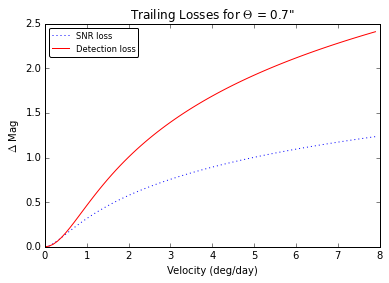

In [39]:
# Summary: 
def dmag(velocity, seeing, texp=30.):
    a_trail = 0.76
    b_trail = 1.16
    a_det = 0.42
    b_det = 0.00
    x = velocity * texp / seeing / 24.0
    dmag = {}
    dmag['trail'] = 1.25 * np.log10(1 + a_trail*x**2/(1+b_trail*x))
    dmag['detect'] = 1.25 * np.log10(1 + a_det*x**2 / (1+b_det*x))
    return dmag

velocities = np.arange(0, 8, 0.1)
for seeing in [0.7]:
    dmags = dmag(velocities, seeing)
    plt.plot(velocities, dmags['trail'], 'b:', label='SNR loss')
    plt.plot(velocities, dmags['detect'], 'r-', label='Detection loss')
    #plt.plot(velocities, 1.25*(np.log10(1+0.67*(velocities*30.0/seeing/24.0))), 'k:')
plt.legend(loc='upper left', fancybox=True, numpoints=1, fontsize='smaller')
plt.xlabel('Velocity (deg/day)')      
plt.ylabel('$\Delta$ Mag')
plt.title('Trailing Losses for $\Theta$ = %.1f"' %0.7)
plt.savefig('trailing_losses.pdf', format='pdf', dpi=600)